<a href="https://colab.research.google.com/github/Nasrin-Akhtar/Credit_Risk_Analysis/blob/main/Credit_risk_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:
import numpy as np
import pandas as pd
from decimal import Decimal, getcontext

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

import scipy.stats as stats
import statsmodels.api as sm
import pylab as py

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


# 2. Data Cleaning and Preprocessing

In [151]:
df=pd.read_csv('/content/Credit_risk_analysis.csv')
df.head()

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,Y,3
1,1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,N,2
2,2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,N,3
3,3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,N,2
4,4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,Y,4


In [152]:
df.shape

(32581, 12)

In [153]:
def summary(df):
    df.shape
    print(f"Dataset has {df.shape[1]} features and {df.shape[0]} observations.")
    summary = pd.DataFrame(index=df.columns)
    summary["Unique"] = df.nunique().values
    summary["Missing_Values"] = df.isnull().sum().values
    summary["Types"] = df.dtypes
    return summary
summary(df)


Dataset has 12 features and 32581 observations.


,Unique,Missing_Values,Types
Id,32581,0,int64
Age,58,0,int64
Income,4295,0,int64
Home,4,0,object
Emp_length,36,895,float64
Intent,6,0,object
Amount,753,0,int64
Rate,348,3116,float64
Status,2,0,int64
Percent_income,77,0,float64


**As there is so 895 null values for employment length, also for rate 3116 null values. Hence, we will have to replace those values.**

In [154]:
print(df['Home'].unique())

['RENT' 'OWN' 'MORTGAGE' 'OTHER']


In [155]:
condition= ((df['Age'] > 100) | (df['Emp_length']> 100))
new_df= df.drop(df[condition].index)

In [156]:
new_age= df[df['Age'] > 100].index
df.drop(new_age , inplace=True)

In [157]:
new_emp = df[df['Emp_length']> 100].index
df.drop(new_emp , inplace=True)

**We have dropped the rows for which values of age and employment length are greater than 100 as it is very unrealistic and it 'll come under outlier**

In [158]:
new_df=new_df.fillna(df["Emp_length"].median())
new_df=new_df=df.fillna(df["Rate"].mean())

**We are filling up the null values by median for employment length as outlier is present there and by mean for rate.**

In [159]:
new_df.drop('Id',axis=1,inplace=True)

In [160]:
new_df.shape #The dimension of dataset after cleaning

(32574, 11)

# 3. Summary Statistics

In [161]:
summary(new_df)

Dataset has 11 features and 32574 observations.


,Unique,Missing_Values,Types
Age,56,0,int64
Income,4294,0,int64
Home,4,0,object
Emp_length,36,0,float64
Intent,6,0,object
Amount,753,0,int64
Rate,349,0,float64
Status,2,0,int64
Percent_income,77,0,float64
Default,2,0,object


**After cleaning there is no null values, 3 categorical features and 8 numerical features**

In [162]:
new_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,32574.0,27.718426,6.204987,20.00,23.00,26.000000,30.00,94.00
Income,32574.0,65878.480813,52531.938809,4000.00,38500.00,55000.000000,79200.00,2039784.00
Emp_length,32574.0,4.953224,4.107363,0.00,2.00,4.000000,7.00,41.00
Amount,32574.0,9588.018051,6320.249598,500.00,5000.00,8000.000000,12200.00,35000.00
Rate,32574.0,11.011529,3.081657,5.42,8.49,11.011529,13.11,23.22
Status,32574.0,0.218180,0.413017,0.00,0.00,0.000000,0.00,1.00
Percent_income,32574.0,0.170202,0.106755,0.00,0.09,0.150000,0.23,0.83
Cred_length,32574.0,5.804108,4.053873,2.00,3.00,4.000000,8.00,30.00


This is the matrix representation of the numerical features provided in the data, from where we can see the mean, median, quantiles, max, min, standard deviation and frequencies. As, we can see mean for the features age, income, loan_amount, percent_income, cred_length  are greater than median hence distributions should be positively skewed.

# 4. Univariate Analysis

In [163]:
def distribution(data,feature):
    sns.displot(data[feature],kind='kde')
    print(data[feature].agg(['skew','kurtosis']))

skew          9.756273
kurtosis    225.038181
Name: Income, dtype: float64


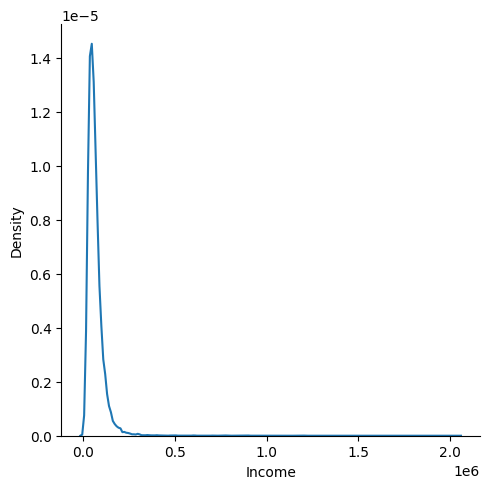

In [164]:
distribution(new_df,'Income')

**Income distribution is positively skewed and leptokurtic i.e fatter tails**

skew        1.192024
kurtosis    1.421923
Name: Amount, dtype: float64


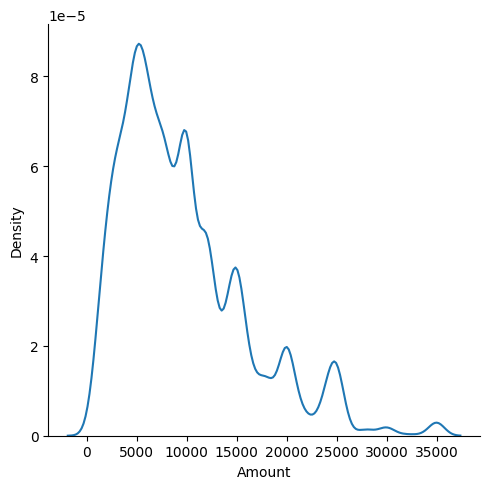

In [165]:
distribution(new_df,'Amount')#rounding error

**Distribution for the loan amount is positively skewed and platykurtic.
From the distribution we can see that there is a pick at every round-up value, which happens in reality. Usually people take loan amount in the round-off form  that can be a reason behind the pick at every rounding off value. Highest pick value founded usually near 5000 and very few people took loan of 35000**

skew        0.219436
kurtosis   -0.425300
Name: Rate, dtype: float64


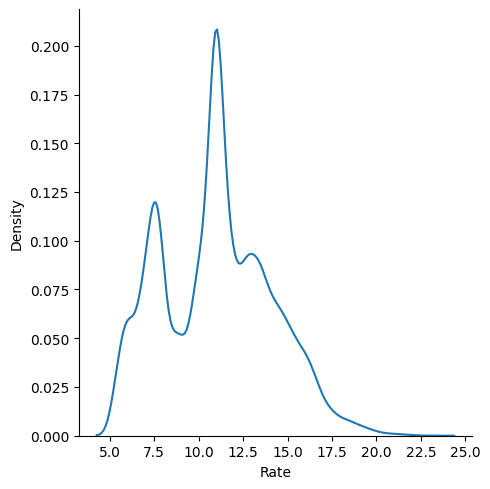

In [166]:
distribution(new_df,'Rate')

**Rate is positively skewed and it is platykurtic.
As 10% of the values are replaced by mean value and which is also equal to median hence there's pick found near 11**

skew        1.660413
kurtosis    3.709803
Name: Cred_length, dtype: float64


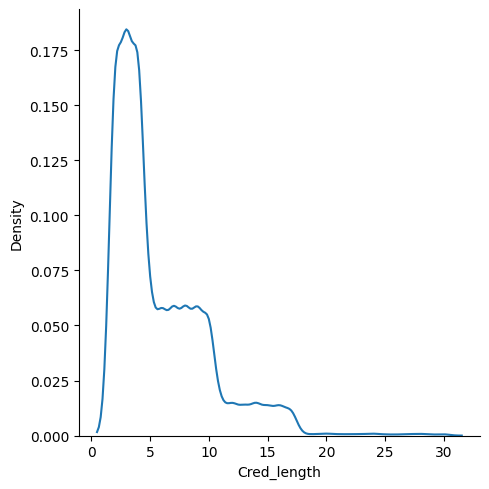

In [167]:
distribution(new_df,'Cred_length')

**In the credit length plot it seems like a step distribution so, we can use binning method which may seems normal distribution**

In [168]:
#cred_length_bin=['Initial','Established','Intermediate','Experienced']
##new_df['cred_length_bin']=pd.cut(new_df['Cred_length'],bins=[0,5,10,17,30],right=False,labels=cred_length_bin)

In [169]:
#age_group=['young','middle_aged','Senior']
#new_df['age_group']=pd.cut(new_df['Age'],bins=[20,40,60,94],right=False,labels=age_group)

In [170]:
new_df.columns

Index(['Age', 'Income', 'Home', 'Emp_length', 'Intent', 'Amount', 'Rate',
       'Status', 'Percent_income', 'Default', 'Cred_length'],
      dtype='object')

In [171]:
selected_columns=['Home', 'Intent', 'Default', 'Cred_length']

def univariate_plotting(new_df):
    for item in selected_columns:
        unique_value=df[item].nunique()
        if df[item].dtypes!='int64' and unique_value<6:
            dummy_df=df[item].value_counts()
            fig=px.pie(dummy_df,names=dummy_df.index,values=dummy_df.values,title=f'Percentage of employees {item}')
            fig.update_layout(height=600,width=500)
            fig.show()
        elif unique_value>25:
            fig=px.histogram(df,x=item,title=f'Graphical representation of {item}',nbins=30, text_auto=False)
            fig.update_layout(xaxis_title=item, yaxis_title='Frequency',height=600,width=800)
            fig.show()
        else:
            fig=px.histogram(df,x=item,title=f'Graphical representation of {item}',color=item, nbins=30, text_auto=False)
            fig.update_layout(xaxis_title=item, yaxis_title='Frequency',height=600,width=800)
            fig.show()

univariate_plotting(new_df)

# 5. Bivariate Analysis

**> 1.  Income Analysis**


In [172]:
def bivariate_plotting(new_df):
    selected_columns=['Home','Emp_length', 'Intent', 'Default', 'Cred_length']
    for item in selected_columns:
        unique_values=df[item].nunique()
        if unique_values>15:
            dummy_df=df.groupby([item])['Income'].mean()
            fig=px.bar(dummy_df,x=dummy_df.index,y=dummy_df.values,title=f'Relation between Income and {item}')
            fig.update_layout(height=600,width=800)
            fig.show()
        elif unique_values<70:
            dummy_df=df.groupby([item])['Income'].mean()
            fig=px.bar(dummy_df,x=dummy_df.index,y=dummy_df.values,color=dummy_df.index,title=f'Salaries with respect to {item}')

            fig.update_layout(height=600,width=800)
            fig.show()
        else:
            dummy_df=df.sort_values(by='Income').groupby([item])['Income'].mean()[-15:]
            fig=px.bar(dummy_df,x=dummy_df.index,y=dummy_df.values,color=dummy_df.index,title=f'Salaries with respect to {item}')
            fig.update_layout(height=600,width=800)
            fig.show()

bivariate_plotting(new_df)

In [173]:
def bivariate_plotting(new_df):
    selected_columns=['Home', 'Intent', 'Cred_length']
    for item in selected_columns:
        unique_values=df[item].nunique()
        if unique_values>15:
            dummy_df=df.groupby([item])['Default'].count()
            fig=px.bar(dummy_df,x=dummy_df.index,y=dummy_df.values,title=f'Relation between Credit Default and {item}')
            fig.update_layout(height=600,width=800)
            fig.show()
        elif unique_values<70:
            dummy_df=df.groupby([item])['Default'].count()
            fig=px.bar(dummy_df,x=dummy_df.index,y=dummy_df.values,color=dummy_df.index,title=f'Relation between Loan amount and {item}')

            fig.update_layout(height=600,width=800)
            fig.show()
        else:
            dummy_df=df.sort_values(by='Default').groupby([item])['Default'].count()[-15:]
            fig=px.bar(dummy_df,x=dummy_df.index,y=dummy_df.values,color=dummy_df.index,title=f'Relation between Loan amount and {item}')
            fig.update_layout(height=600,width=800)
            fig.show()

bivariate_plotting(new_df)

In [174]:
def bivariate_plotting(new_df):
    selected_columns=['Home', 'Intent', 'Default', 'Cred_length']
    for item in selected_columns:
        unique_values=df[item].nunique()
        if unique_values>15:
            dummy_df=df.groupby([item])['Amount'].mean()
            fig=px.bar(dummy_df,x=dummy_df.index,y=dummy_df.values,title=f'Relation between Loan amount and {item}')
            fig.update_layout(height=600,width=800)
            fig.show()
        elif unique_values<70:
            dummy_df=df.groupby([item])['Amount'].mean()
            fig=px.bar(dummy_df,x=dummy_df.index,y=dummy_df.values,color=dummy_df.index,title=f'Relation between Loan amount and {item}')

            fig.update_layout(height=600,width=800)
            fig.show()
        else:
            dummy_df=df.sort_values(by='Amount').groupby([item])['Amount'].mean()[-15:]
            fig=px.bar(dummy_df,x=dummy_df.index,y=dummy_df.values,color=dummy_df.index,title=f'Relation between Loan amount and {item}')
            fig.update_layout(height=600,width=800)
            fig.show()

bivariate_plotting(new_df)

# Inferential Statistics


**H0 : There is a significant association between the categorical variables Default and Home**
**H1 : There is no significant association between the categorical variables Default and Home**

In [175]:
df_table= pd.crosstab(new_df['Default'],new_df['Home'])
print(df_table)

Home     MORTGAGE  OTHER   OWN   RENT
Default                              
N           11447     78  2140  13165
Y            1994     29   444   3277


In [176]:
chi_t=stats.chi2_contingency(df_table)
chi_t

Chi2ContingencyResult(statistic=139.1693440286869, pvalue=5.709005102385149e-30, dof=3, expected_freq=array([[11070.85497636,    88.13194572,  2128.34530607, 13542.66777184],
       [ 2370.14502364,    18.86805428,   455.65469393,  2899.33222816]]))

 Here test statistic is Chi-Squared distributed. However, #in our result Test statistic: 139.169 #degree of freedom: 3 As p value <0.05 at 5% level of significance we reject null hypothesis

H0 : There is a significant association between the categorical variables Default and Intent H1 : There is no significant association between the categorical variables Default and Intent

In [177]:
df_table1= pd.crosstab(new_df['Default'],new_df['Intent'])
print(df_table1)

Intent   DEBTCONSOLIDATION  EDUCATION  HOMEIMPROVEMENT  MEDICAL  PERSONAL  \
Default                                                                     
N                     4277       5349             2909     5009      4562   
Y                      935       1102              696     1062       957   

Intent   VENTURE  
Default           
N           4724  
Y            992  


In [178]:
chi_t=stats.chi2_contingency(df_table1,lambda_='log-likelihood')
chi_t

Chi2ContingencyResult(statistic=9.194379860907706, pvalue=0.10155768954988093, dof=5, expected_freq=array([[4292.93178609, 5313.45029778, 2969.30527415, 5000.45834101,
        4545.79634064, 4708.05796034],
       [ 919.06821391, 1137.54970222,  635.69472585, 1070.54165899,
         973.20365936, 1007.94203966]]))

Here test statistic is Chi-Squared distributed. However, #in our result Test statistic: 9.19 #degree of freedom: 5 ## p value:0.101 As p value >0.05 at 5% level of significance we fail to reject our null hypothesis

<ipython-input-179-ad460fac0624>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

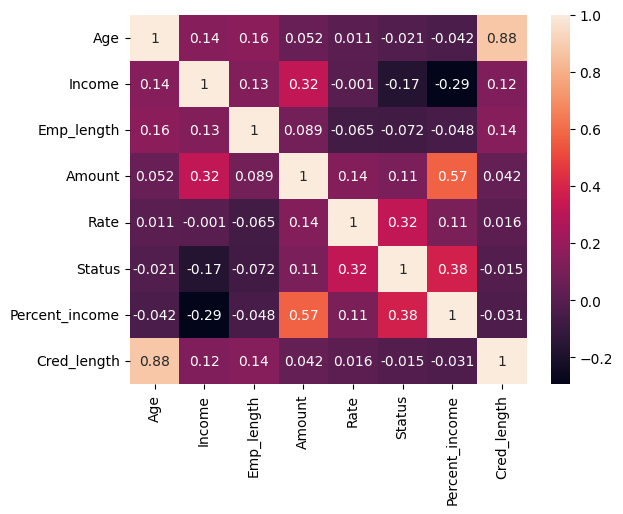

In [179]:
sns.heatmap(new_df.corr(),annot=True)

As correlation coefficient between cred_length and age is way too high i.e 0.88, which can cause multicollinearity so, let's drop the cred_length

In [180]:
cat_col=['Home','Intent','Default']
dummy=pd.get_dummies(new_df[cat_col],drop_first=True,dtype=int)
print(dummy)

       Home_OTHER  Home_OWN  Home_RENT  Intent_EDUCATION  \
1               0         1          0                 1   
2               0         0          0                 0   
3               0         0          1                 0   
4               0         0          1                 0   
5               0         1          0                 0   
...           ...       ...        ...               ...   
32576           0         0          0                 0   
32577           0         0          0                 0   
32578           0         0          1                 0   
32579           0         0          0                 0   
32580           0         0          1                 0   

       Intent_HOMEIMPROVEMENT  Intent_MEDICAL  Intent_PERSONAL  \
1                           0               0                0   
2                           0               1                0   
3                           0               1                0   
4              

In [181]:
dummy_df=pd.concat([new_df,dummy],axis=1)
dummy_df.drop(['Home','Intent','Default','Cred_length'],axis=1,inplace=True)
dummy_df.head()

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Home_OTHER,Home_OWN,Home_RENT,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Default_Y
1,21,9600,5.0,1000,11.14,0,0.10,0,1,0,1,0,0,0,0,0
2,25,9600,1.0,5500,12.87,1,0.57,0,0,0,0,0,1,0,0,0
3,23,65500,4.0,35000,15.23,1,0.53,0,0,1,0,0,1,0,0,0
4,24,54400,8.0,35000,14.27,1,0.55,0,0,1,0,0,1,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,0,1,0,0,0,0,0,1,0


In [182]:
X=dummy_df.copy()
y=X.pop('Status')

In [183]:
dummy_df.corr()

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Home_OTHER,Home_OWN,Home_RENT,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Default_Y
Age,1.000000,0.140497,0.162167,0.051751,0.011307,-0.020687,-0.041587,-0.008463,-0.000941,-0.031185,-0.093180,0.076646,0.021567,0.034226,-0.013820,0.007223
Income,0.140497,1.000000,0.131334,0.317497,-0.001042,-0.168485,-0.294558,0.011485,-0.044946,-0.209399,-0.016714,0.051513,-0.040464,0.007845,0.003969,-0.002524
Emp_length,0.162167,0.131334,1.000000,0.089486,-0.064922,-0.071978,-0.047518,-0.017765,0.043446,-0.233548,-0.039130,0.028845,-0.000826,0.008885,0.010439,-0.033870
Amount,0.051751,0.317497,0.089486,1.000000,0.139478,0.105240,0.572420,0.013502,-0.025919,-0.116354,-0.008373,0.043118,-0.024872,-0.001288,-0.000514,0.038875
Rate,0.011307,-0.001042,-0.064922,0.139478,1.000000,0.319302,0.114426,0.016679,-0.013060,0.131561,-0.008968,0.019810,0.006786,-0.001951,-0.008487,0.477115
Status,-0.020687,-0.168485,-0.071978,0.105240,0.319302,1.000000,0.379250,0.012542,-0.101981,0.238416,-0.055298,0.036596,0.056582,-0.021229,-0.078189,0.179002
Percent_income,-0.041587,-0.294558,-0.047518,0.572420,0.114426,0.379250,1.000000,0.011702,0.051076,0.116774,-0.000037,-0.015489,0.012743,-0.004303,0.001563,0.035617
Home_OTHER,-0.008463,0.011485,-0.017765,0.013502,0.016679,0.012542,0.011702,1.000000,-0.016851,-0.057957,-0.005641,0.000271,-0.004054,-0.000184,0.010189,0.014264
Home_OWN,-0.000941,-0.044946,0.043446,-0.025919,-0.013060,-0.101981,0.051076,-0.016851,1.000000,-0.296341,0.004635,0.011596,-0.013884,0.002481,0.099319,-0.003474
Home_RENT,-0.031185,-0.209399,-0.233548,-0.116354,0.131561,0.238416,0.116774,-0.057957,-0.296341,1.000000,0.003667,-0.055908,0.057649,-0.011419,-0.034577,0.060847


In [184]:
scaler=StandardScaler()
x_scaled = scaler.fit_transform(X)

In [185]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled,y, test_size=0.2,random_state=42)

In [186]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y)

(26059, 15)
(6515, 15)
(26059,)
(6515,)
1        0
2        1
3        1
4        1
5        1
        ..
32576    0
32577    0
32578    1
32579    0
32580    0
Name: Status, Length: 32574, dtype: int64


In [187]:
dummy_df

,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Home_OTHER,Home_OWN,Home_RENT,Intent_EDUCATION,Intent_HOMEIMPROVEMENT,Intent_MEDICAL,Intent_PERSONAL,Intent_VENTURE,Default_Y
1,21,9600,5.0,1000,11.14,0,0.10,0,1,0,1,0,0,0,0,0
2,25,9600,1.0,5500,12.87,1,0.57,0,0,0,0,0,1,0,0,0
3,23,65500,4.0,35000,15.23,1,0.53,0,0,1,0,0,1,0,0,0
4,24,54400,8.0,35000,14.27,1,0.55,0,0,1,0,0,1,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0,0.11,0,0,0,0,0,0,1,0,0
32577,54,120000,4.0,17625,7.49,0,0.15,0,0,0,0,0,0,1,0,0
32578,65,76000,3.0,35000,10.99,1,0.46,0,0,1,0,1,0,0,0,0
32579,56,150000,5.0,15000,11.48,0,0.10,0,0,0,0,0,0,1,0,0


In [188]:
models=[('Logistic_Regression',LogisticRegression()),
       ('Decision_Tree_Classifier',DecisionTreeClassifier()),
       ('Bagging',BaggingClassifier()),
        ('Random_Forest',RandomForestClassifier()),
        ('XGBClassifier',XGBClassifier())]

In [189]:
for name,model in models:
    pipeline = Pipeline([('model',model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score=accuracy_score(y_test,y_pred)
    report = classification_report(y_test,y_pred)
    print(name)
    print('accuracy_score:',score)
    print(report)
    print("-"*100)


Logistic_Regression
accuracy_score: 0.8483499616270146
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      5099
           1       0.74      0.47      0.58      1416

    accuracy                           0.85      6515
   macro avg       0.80      0.71      0.74      6515
weighted avg       0.84      0.85      0.84      6515

----------------------------------------------------------------------------------------------------
Decision_Tree_Classifier
accuracy_score: 0.8827321565617805
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      5099
           1       0.71      0.77      0.74      1416

    accuracy                           0.88      6515
   macro avg       0.82      0.84      0.83      6515
weighted avg       0.89      0.88      0.88      6515

----------------------------------------------------------------------------------------------------
Bagging
accuracy_score: 0.922

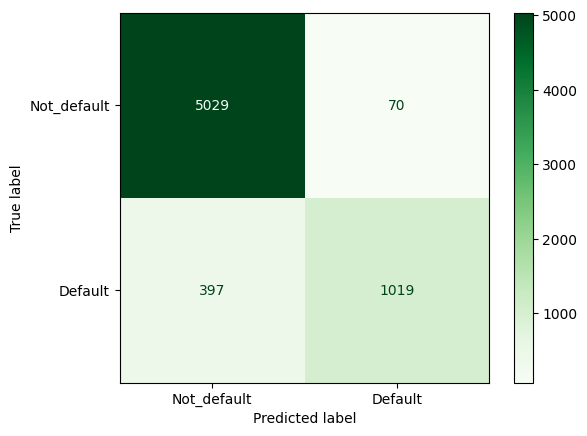

In [190]:
pipeline = Pipeline([('XGBClassifier',XGBClassifier())])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = plt.cm.Greens, normalize = None, display_labels = ['Not_default', 'Default']))

In [191]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.8, 0.9, 1.0]}
grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=5, verbose=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [192]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Model Accuracy: {accuracy:.2f}')

Best Model Accuracy: 0.93


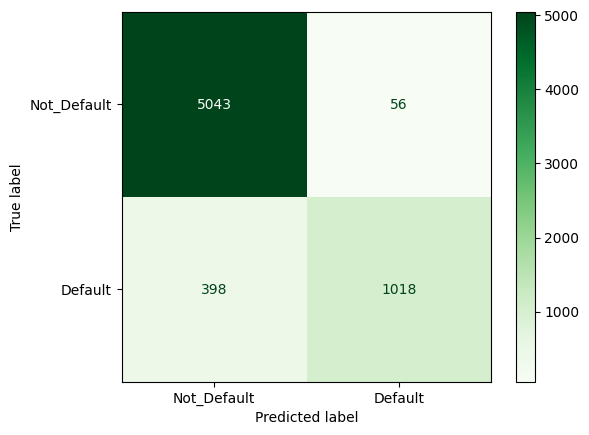

In [193]:
print(ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = plt.cm.Greens, normalize = None, display_labels = ['Not_Default', 'Default']))